In [1]:
%matplotlib inline

In [2]:
import os, sys
import re
import glob
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from uncertainties import ufloat

In [3]:
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["xtick.major.width"] = 1.0
plt.rcParams["ytick.major.width"] = 1.0
plt.rcParams["font.size"] = 8
plt.rcParams["axes.linewidth"] = 1.5

In [4]:
formatter = mticker.ScalarFormatter(useMathText=False)
formatter.set_scientific(False)
formatter.set_useOffset(False)

In [5]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

In [6]:
import ipynb_path

root_dir = os.path.dirname(ipynb_path.get())
os.chdir(root_dir)

In [7]:
Ha_to_meV = 27.2114 * 1000

In [8]:
# def read
def read_lrdmc_energy(file):
    with open(file, "r") as f:
        lines = f.readlines()
        for line in lines:
            if re.match(".*Total.*Energy:*", line):
                e_mean = float(line.split()[4])
                e_std = float(line.split()[6])
                return ufloat(e_mean, e_std)
        return ufloat(np.nan, np.nan)

In [9]:
# find the last LRDMC file
def find_max_out_lrdmc_cont(folder_path):
    pattern = re.compile(r"out_lrdmc_cont(\d+)\.o")
    max_x = -1
    max_file = None

    for file_path in glob.glob(os.path.join(folder_path, "out_lrdmc_cont*.o")):
        match = pattern.search(os.path.basename(file_path))
        if match:
            x_value = int(match.group(1))
            if x_value > max_x:
                max_x = x_value
                max_file = file_path

    return max_file

In [10]:
# define functions for fitting.
def fit_E_LRDMC(x, y, y_err, xs, monte_calro_loop=100, order=1):
    val_pd = pd.DataFrame(index=[], columns=x)
    val_pd_plot = pd.DataFrame(index=[], columns=xs)
    y_zero_list = []
    sigma_list = []
    for v in y:
        sigma_list.append(np.random.randn(monte_calro_loop))

    for m in range(monte_calro_loop):
        y_gen = []
        for i, v in enumerate(y):
            y_gen.append(y[i] + y_err[i] * sigma_list[i][m])

        # polyfit
        w = np.polyfit(x, y_gen, order)
        ys = np.polyval(w, x)
        ys_plot = np.polyval(w, xs)
        c = np.poly1d(w).deriv(1)
        ys_deriv = c(x)
        ys_deriv_plot = c(xs)

        # record
        record = pd.Series(ys, index=val_pd.columns)
        val_pd = val_pd._append(record, ignore_index=True)

        # record for plot
        record = pd.Series(ys_plot, index=val_pd_plot.columns)
        val_pd_plot = val_pd_plot._append(record, ignore_index=True)

        # extrapolated energy
        c = np.poly1d(w)
        y_zero_list.append(c(0.0))

    y_zero_list = np.array(y_zero_list)
    y_mean = np.array(list(val_pd.mean()))
    y_std = np.array(list(val_pd.std()))
    y_mean_plot = np.array(list(val_pd_plot.mean()))
    y_std_plot = np.array(list(val_pd_plot.std()))

    return y_zero_list, y_mean, y_std, y_mean_plot, y_std_plot

In [11]:
# DLTM
alat_list = [0.10, 0.15, 0.20, 0.25, 0.30]

"""
# methane
methane_lrdmc_dirs = [os.path.join(root_dir, '01m_ccecp_ccpvtz', 'lrdmc_dlatm', f'alat_{alat:.2f}') for alat in alat_list]
methane_lrdmc_files = [find_max_out_lrdmc_cont(methane_lrdmc_dir) for methane_lrdmc_dir in methane_lrdmc_dirs]
methane_lrdmc_energy = [read_lrdmc_energy(methane_lrdmc_file) for methane_lrdmc_file in methane_lrdmc_files]
"""

# water
water_lrdmc_dirs = [os.path.join(root_dir, "02w_ccecp_ccpvtz", "lrdmc_dlatm", f"alat_{alat:.2f}") for alat in alat_list]
water_lrdmc_files = [find_max_out_lrdmc_cont(water_lrdmc_dir) for water_lrdmc_dir in water_lrdmc_dirs]
water_lrdmc_energy = [read_lrdmc_energy(water_lrdmc_file) for water_lrdmc_file in water_lrdmc_files]

"""
# water-methane
water_methane_lrdmc_dirs = [os.path.join(root_dir, '03m_w_ccecp_ccpvtz', '02lrdmc_dlatm', f'alat_{alat:.2f}') for alat in alat_list]
water_methane_lrdmc_files = [find_max_out_lrdmc_cont(water_methane_lrdmc_dir) for water_methane_lrdmc_dir in water_methane_lrdmc_dirs]
water_methane_lrdmc_energy = [read_lrdmc_energy(water_methane_lrdmc_file) for water_methane_lrdmc_file in water_methane_lrdmc_files]

# binding energy
binding_energy = [(mw - m - w) * Ha_to_meV for m,w,mw in zip(methane_lrdmc_energy, water_lrdmc_energy, water_methane_lrdmc_energy)]
"""

"\n# water-methane\nwater_methane_lrdmc_dirs = [os.path.join(root_dir, '03m_w_ccecp_ccpvtz', '02lrdmc_dlatm', f'alat_{alat:.2f}') for alat in alat_list]\nwater_methane_lrdmc_files = [find_max_out_lrdmc_cont(water_methane_lrdmc_dir) for water_methane_lrdmc_dir in water_methane_lrdmc_dirs]\nwater_methane_lrdmc_energy = [read_lrdmc_energy(water_methane_lrdmc_file) for water_methane_lrdmc_file in water_methane_lrdmc_files]\n\n# binding energy\nbinding_energy = [(mw - m - w) * Ha_to_meV for m,w,mw in zip(methane_lrdmc_energy, water_lrdmc_energy, water_methane_lrdmc_energy)]\n"

In [12]:
water_lrdmc_energy

[-17.23512+/-0.000118,
 -17.23572+/-0.000156,
 -17.23635+/-0.00011,
 -17.23686+/-0.000105,
 -17.23692+/-0.000107]

-17.23455+/-0.00016


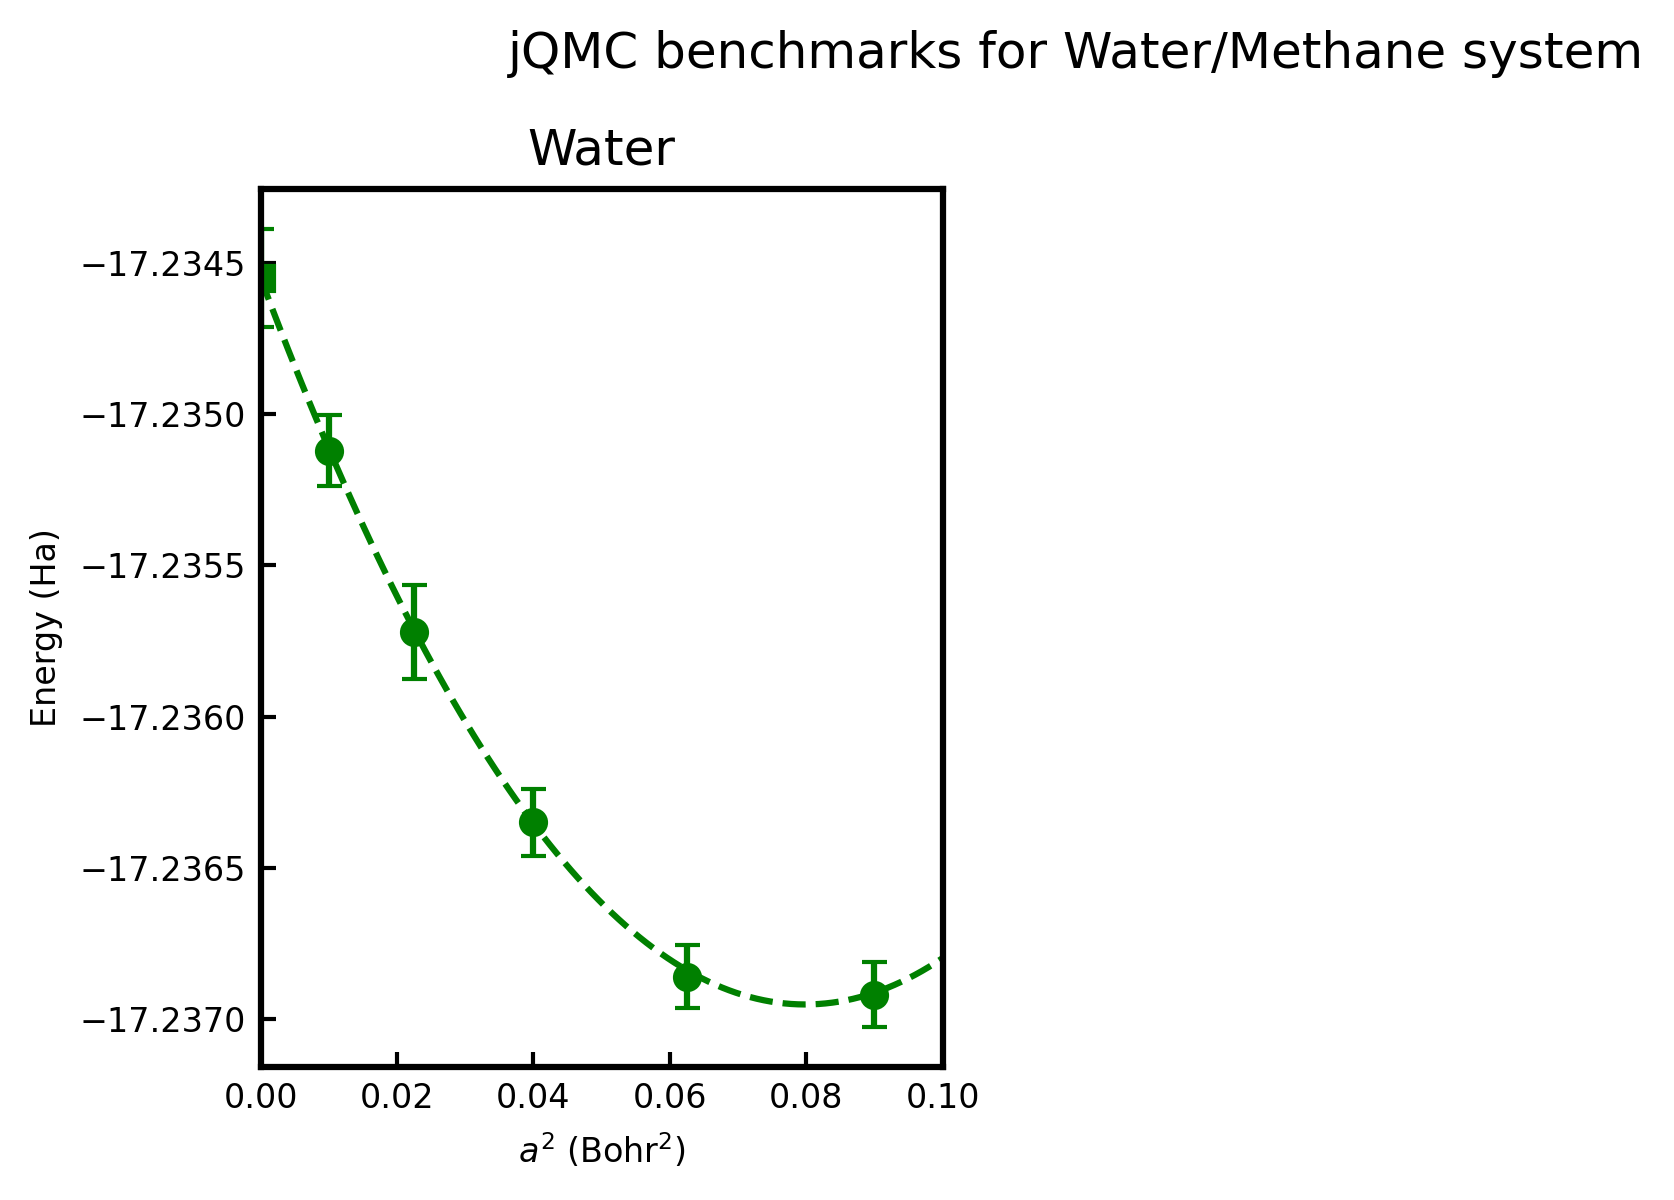

In [15]:
# plot Graph
fig = plt.figure(figsize=(12, 4), facecolor="white", dpi=300, tight_layout=True)
fig.suptitle(rf"jQMC benchmarks for Water/Methane system", fontsize=12)
x_min = 0.0
x_max = 0.1

"""
# methane
ax1 = fig.add_subplot(1,4,1)
ax1.set_title('Methane', fontsize=12)
ax1.set_xlabel(r'$a^2$ (Bohr$^2$)')
ax1.set_ylabel('Energy (Ha)')
ax1.set_xlim([x_min,x_max])
x=np.array(alat_list)**2
xs=np.linspace(x_min,x_max,100)
y=np.array([e.n for e in methane_lrdmc_energy])
yerr=np.array([e.s for e in methane_lrdmc_energy])
y_zero_list, y_mean, y_std, y_mean_plot, y_std_plot = fit_E_LRDMC(x, y, yerr, xs)
E_ext = ufloat(np.mean(y_zero_list), np.std(y_zero_list))
ax1.errorbar(x, y, yerr=yerr, color="g", marker="o", ls='', alpha=1.0, capsize=3)
ax1.plot(xs, y_mean_plot, color="g", marker="", ls='--')
ax1.errorbar(0.0, E_ext.n, yerr=E_ext.s, color="g", marker="s", label='Extrapolated', alpha=1.0, capsize=3)
ax1.yaxis.set_major_formatter(formatter)
print(E_ext)
"""

# water
ax2 = fig.add_subplot(1, 4, 2)
ax2.set_title("Water", fontsize=12)
ax2.set_xlabel(r"$a^2$ (Bohr$^2$)")
ax2.set_ylabel("Energy (Ha)")
ax2.set_xlim([x_min, x_max])
x = np.array(alat_list) ** 2
xs = np.linspace(x_min, x_max, 100)
y = np.array([e.n for e in water_lrdmc_energy])
yerr = np.array([e.s for e in water_lrdmc_energy])
y_zero_list, y_mean, y_std, y_mean_plot, y_std_plot = fit_E_LRDMC(x, y, yerr, xs, order=2)
E_ext = ufloat(np.mean(y_zero_list), np.std(y_zero_list))
ax2.errorbar(x, y, yerr=yerr, color="g", marker="o", ls="", alpha=1.0, capsize=3)
ax2.plot(xs, y_mean_plot, color="g", marker="", ls="--")
ax2.errorbar(0.0, E_ext.n, yerr=E_ext.s, color="g", marker="s", label="Extrapolated", alpha=1.0, capsize=3)
ax2.yaxis.set_major_formatter(formatter)
print(E_ext)

"""
# water--methane
ax3 = fig.add_subplot(1,4,3)
ax3.set_title('Methane-Water', fontsize=12)
ax3.set_xlabel(r'$a^2$ (Bohr$^2$)')
ax3.set_ylabel('Energy (Ha)')
ax3.set_xlim([x_min,x_max])
x=np.array(alat_list)**2
xs=np.linspace(x_min,x_max,100)
y=np.array([e.n for e in water_methane_lrdmc_energy])
yerr=np.array([e.s for e in water_methane_lrdmc_energy])
y_zero_list, y_mean, y_std, y_mean_plot, y_std_plot = fit_E_LRDMC(x, y, yerr, xs)
E_ext = ufloat(np.mean(y_zero_list), np.std(y_zero_list))
ax3.errorbar(x, y, yerr=yerr, color="g", marker="o", ls='', alpha=1.0, capsize=3)
ax3.plot(xs, y_mean_plot, color="g", marker="", ls='--')
ax3.errorbar(0.0, E_ext.n, yerr=E_ext.s, color="g", marker="s", label='Extrapolated', alpha=1.0, capsize=3)
ax3.yaxis.set_major_formatter(formatter)

# water--methane
ax4 = fig.add_subplot(1,4,4)
ax4.set_title('Binding Energy', fontsize=12)
ax4.set_xlabel(r'$a^2$ (Bohr$^2$)')
ax4.set_ylabel('Binding Energy (meV)')
ax4.set_xlim([x_min,x_max])
x=np.array(alat_list)**2
xs=np.linspace(x_min,x_max,100)
y=np.array([e.n for e in binding_energy])
yerr=np.array([e.s for e in binding_energy])
y_zero_list, y_mean, y_std, y_mean_plot, y_std_plot = fit_E_LRDMC(x, y, yerr, xs)
E_ext = ufloat(np.mean(y_zero_list), np.std(y_zero_list))
ax4.errorbar(x, y, yerr=yerr, color="g", marker="o", ls='', alpha=1.0, capsize=3)
ax4.plot(xs, y_mean_plot, color="g", marker="", ls='--')
ax4.errorbar(0.0, E_ext.n, yerr=E_ext.s, color="g", marker="s", label='Extrapolated', alpha=1.0, capsize=3)

print(f"Binding energy of Methane-Water dimer = {E_ext:.2uS} meV")
"""

plt.show()